In [1]:
import chardet
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn import metrics, preprocessing, datasets
from sklearn.preprocessing import normalize, OneHotEncoder
from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Input, BatchNormalization, Dropout, Activation, GlobalAveragePooling1D
import random
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau
import os, shutil, time
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import datetime 
from matplotlib.patches import Polygon
import matplotlib.lines as mlines
import collections
%matplotlib inline

In [2]:
dfcovid1 = pd.read_csv('https://storage.googleapis.com/covid19-open-data/v2/geography.csv')
dfcovid1 = dfcovid1[['key','latitude','longitude']]
dfcovid1 = dfcovid1.dropna(axis='index', how='any', subset=['key'])
dfcovid1[dfcovid1['key'].str.startswith('IN_')]

,key,latitude,longitude
12223,IN_AN,11.680000,92.770000
12224,IN_AN_NIC,9.157343,92.761087
12225,IN_AN_NMA,12.920000,92.900000
12226,IN_AN_SAS,11.670000,92.740000
12227,IN_AP,16.500000,80.600000
...,...,...,...
12943,IN_WB_MRS,24.140000,88.260000
12944,IN_WB_N24,22.130000,88.500000
12945,IN_WB_NAD,23.400000,88.500000
12946,IN_WB_PRL,23.333333,86.366667


In [3]:
dfcovid2 = pd.read_csv('https://storage.googleapis.com/covid19-open-data/v2/epidemiology.csv')
dfcovid2 = dfcovid2.dropna(axis='index', how='any', subset=['key'])

In [4]:
dfcovid3 = pd.read_csv('https://storage.googleapis.com/covid19-open-data/v2/demographics.csv')
dfcovid3 = dfcovid3[['key','population']]
dfcovid3

,key,population
0,AD,77265.0
1,AE,9890400.0
2,AF,38928341.0
3,AF_BAL,1509183.0
4,AF_BAM,495557.0
...,...,...
21303,ZA_WC_DC3,258176.0
21304,ZA_WC_DC4,574265.0
21305,ZA_WC_DC5,71011.0
21306,ZM,18383956.0


In [5]:
main=pd.read_csv(r'./main.csv',encoding='utf-8')
main = main[['key','subregion2_name']]
main

C:\Users\cccha\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (9,102) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,key,subregion2_name
0,AD,NaN
1,AE,NaN
2,AF,NaN
3,AF_BAL,NaN
4,AF_BAM,NaN
...,...,...
22573,ZA_WC_DC3,Overberg
22574,ZA_WC_DC4,Garden Route
22575,ZA_WC_DC5,Central Karoo
22576,ZM,NaN


In [6]:
d = pd.DataFrame({ 'date' : { '1':'2021-01-17'} }) 
d['date']=pd.to_datetime(d['date'])

table4=pd.merge(dfcovid2,dfcovid1,on=['key'])
table4['date1']=table4['date']
table4['date']=pd.to_datetime(table4['date'])#date=>日期型態，date1=>字串型態
table4=table4[table4['key'].str.startswith('IN_')]
table4=table4[table4['date']>d['date'][0]].sort_values(by=['date'])
table4=pd.merge(table4,dfcovid3,on=['key'])
table4['total_%confirmed']=table4['total_confirmed']/table4['population']
table4['new_%confirmed']=table4['new_confirmed']/table4['population']
table4=pd.merge(table4,main,on=['key'])
table4.index = range(len(table4))
# table4#印度各地在d之後的疫情資料、緯度座標、人口數、總人口確診百分數
table4
#collections.Counter(table4['key'].values)

,date,key,new_confirmed,new_deceased,new_recovered,new_tested,total_confirmed,total_deceased,total_recovered,total_tested,latitude,longitude,date1,population,total_%confirmed,new_%confirmed,subregion2_name
0,2021-01-18,IN_AN,5.0,0.0,1.0,NaN,4984.0,62.0,4888.0,NaN,11.68,92.77,2021-01-18,356152.0,0.013994,0.000014,NaN
1,2021-01-19,IN_AN,1.0,0.0,0.0,NaN,4985.0,62.0,4888.0,NaN,11.68,92.77,2021-01-19,356152.0,0.013997,0.000003,NaN
2,2021-01-20,IN_AN,2.0,0.0,3.0,NaN,4987.0,62.0,4891.0,NaN,11.68,92.77,2021-01-20,356152.0,0.014002,0.000006,NaN
3,2021-01-21,IN_AN,0.0,0.0,4.0,NaN,4987.0,62.0,4895.0,NaN,11.68,92.77,2021-01-21,356152.0,0.014002,0.000000,NaN
4,2021-01-22,IN_AN,1.0,0.0,3.0,NaN,4988.0,62.0,4898.0,NaN,11.68,92.77,2021-01-22,356152.0,0.014005,0.000003,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77875,2021-05-25,IN_BR,3306.0,104.0,6015.0,NaN,695726.0,4746.0,655850.0,NaN,25.37,85.13,2021-05-25,103804637.0,0.006702,0.000032,NaN
77876,2021-05-26,IN_BR,2603.0,99.0,6641.0,NaN,698329.0,4845.0,662491.0,NaN,25.37,85.13,2021-05-26,103804637.0,0.006727,0.000025,NaN
77877,2021-05-27,IN_BR,2568.0,98.0,5015.0,NaN,700897.0,4943.0,667506.0,NaN,25.37,85.13,2021-05-27,103804637.0,0.006752,0.000025,NaN
77878,2021-05-28,IN_BR,1785.0,61.0,5362.0,NaN,702682.0,5004.0,672868.0,NaN,25.37,85.13,2021-05-28,103804637.0,0.006769,0.000017,NaN


In [13]:
table4[['total_%confirmed','new_%confirmed']].describe(percentiles=[.1,.2,.3,.4,.5,.6,.7,.8,.9])

,total_%confirmed,new_%confirmed
count,77880.000000,7.787900e+04
mean,0.010277,9.671174e-05
std,0.013447,2.372029e-04
min,0.000217,-1.799463e-03
10%,0.001598,0.000000e+00
20%,0.002388,4.281154e-07
30%,0.003338,1.707087e-06
40%,0.004605,4.316795e-06
50%,0.006207,1.097608e-05
60%,0.008004,2.941199e-05


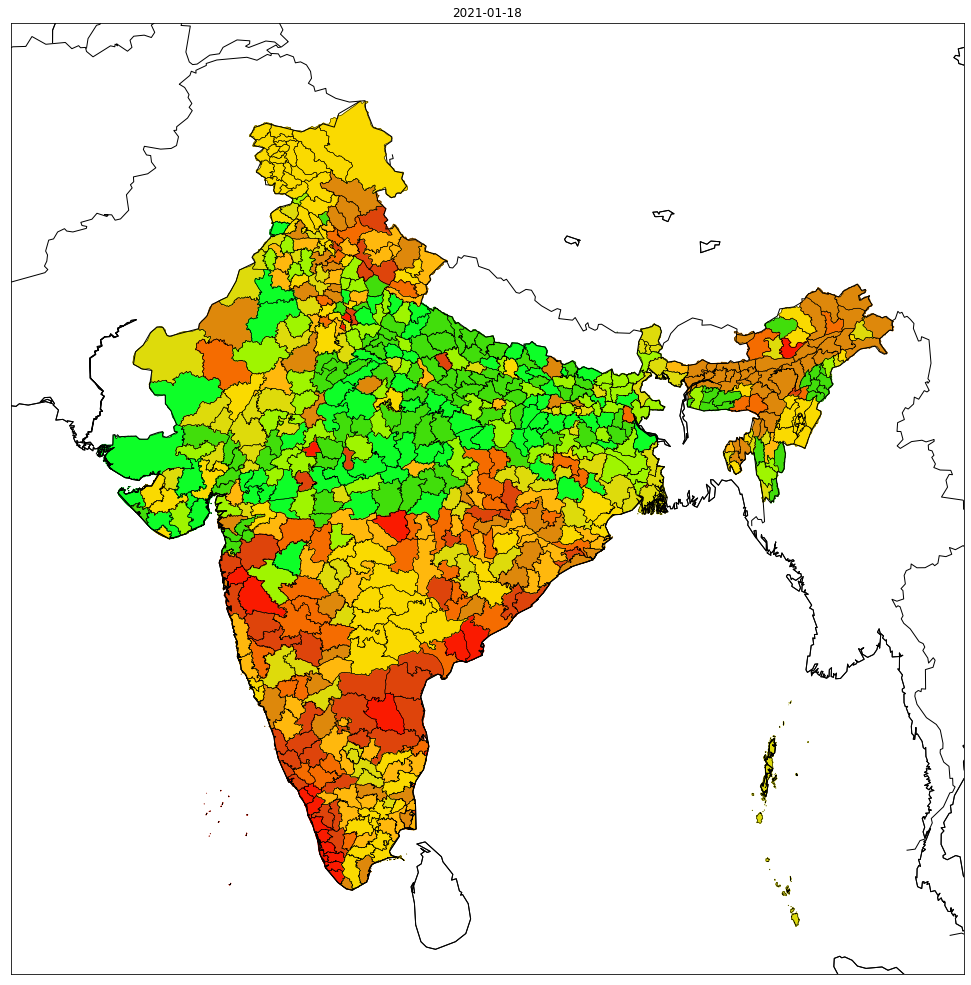

In [17]:
#印度嚴重程度展示圖(按排名%數)，y的range()可以控制印出d後y天(越嚴重越深色)
#fig=plt.figure(figsize=(120, 100),dpi=200)
for y in range(1):
    table3=table4.copy()
    table3=table3[table3['date']==(d['date'][0]+datetime.timedelta(days=y+1))]
    table3=table3.sort_values(by=['total_%confirmed'],ascending=False)
    table3.index = range(len(table3))
    table3['排名']=1-(table3.index+1)/len(table3)
    m = Basemap(projection='mill',
                llcrnrlat = 5,
                llcrnrlon = 65,
                urcrnrlat = 38,
                urcrnrlon = 100,
                resolution='l')
    fig=plt.figure(figsize=(28, 17.5))
    ax=fig.add_subplot(1,1,1)#一張圖一個維度
    m.drawcoastlines()
    m.drawcountries(linewidth=1)#國際線
    m.drawstates(color='#272727')
    m.drawcounties(color='#4F4F4F')
    m.drawcoastlines(linewidth=1)#海岸線
    m.readshapefile('./gadm36_IND_2', 'comarques')
    city=table3['subregion2_name'] #有疫情的城市名
    confirm=table3['total_%confirmed'] 
    data_dict={city[i]:confirm[i] for i in range(len(city))} #構造成字典數據格式方便後面畫圖調用
    comar=m.comarques #經緯度數據
    comar_info=m.comarques_info #基本資料
    for info, shape in zip(comar_info, comar): 
        city_name=info["NAME_2"] 
        for key in data_dict.keys():
            #color='#FFFFFF'
            if key == city_name:
                #print(data_dict[key])  #測試
                if data_dict[key]>=0 and data_dict[key]<=0.001596:
                    color='#41DE0B'
                    a1 = mlines.Line2D([], [], color=color, marker='D', ls='', label='91%~100%', markersize=3.5)
                elif data_dict[key]>0.001596 and data_dict[key]<=0.002377:
                    color='#0DFF28'
                    a2 = mlines.Line2D([], [], color=color, marker='D', ls='', label='81%~90%', markersize=3.5)
                elif data_dict[key]>0.002377 and data_dict[key]<=0.003312:
                    color='#9FF500'
                    a3 = mlines.Line2D([], [], color=color, marker='D', ls='', label='71%~80%', markersize=3.5)
                elif data_dict[key]>0.003312 and data_dict[key]<=0.004582:
                    color='#DEDB0B'
                    a4 = mlines.Line2D([], [], color=color, marker='D', ls='', label='61%~70%', markersize=3.5)
                elif data_dict[key]>0.004582 and data_dict[key]<=0.006185:
                    color='#FADA00'
                    a5 = mlines.Line2D([], [], color=color, marker='D', ls='', label='51%~60%', markersize=3.5)
                elif data_dict[key]>0.006185 and data_dict[key]<=0.007954:
                    color='#FFB80D'
                    a6 = mlines.Line2D([], [], color=color, marker='D', ls='', label='41%~50%', markersize=3.5)
                elif data_dict[key]>0.007954 and data_dict[key]<=0.010258:
                    color='#DE880B'
                    a7 = mlines.Line2D([], [], color=color, marker='D', ls='', label='31%~40%', markersize=3.5)
                elif data_dict[key]>0.010258 and data_dict[key]<=0.014290:
                    color='#F56C00'
                    a8 = mlines.Line2D([], [], color=color, marker='D', ls='', label='21%~30%', markersize=3.5)
                elif data_dict[key]>0.014290 and data_dict[key]<=0.023527:
                    color='#DE440B'
                    a9 = mlines.Line2D([], [], color=color, marker='D', ls='', label='11%~20%', markersize=3.5)
                else:
                    color='#FA1A00'
                    a10 = mlines.Line2D([], [], color=color, marker='D', ls='', label=' 0%~10%', markersize=3.5)
        poly=Polygon(shape, facecolor=color, edgecolor=color)
        ax.add_patch(poly)
    plt.title(table3['date1'][0])
    plt.savefig(table3['date1'][0] +'.png')
plt.show()